In [13]:
import os
import copy
import time
import random as rd
from datetime import datetime, timedelta
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import torch
from torch import nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import alpaca_trade_api.rest as rest

In [14]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
rd.seed(seed)

In [15]:
# Step 1: Set Up the Alpaca API Connection
load_dotenv()
API_KEY = os.getenv('ALPACA_API_KEY')
SECRET_KEY = os.getenv('ALPACA_SECRET_KEY')
BASE_URL = 'https://paper-api.alpaca.markets'

In [16]:
# Initialize the API
api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

In [17]:
# Constants
symbol = 'AAPL'
backcandles = 60
timeframe=rest.TimeFrame(2, rest.TimeFrameUnit.Hour)
start_date = '2023-01-01'
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date = (start_date_dt + timedelta(days=365)).strftime('%Y-%m-%d') 

In [18]:
# Step 2: Fetch Historical Data
def get_historical_data(symbol, timeframe, start_date, end_date, limit=10000):
    try:
        # Fetch data from Alpaca
        bars = api.get_bars(
            symbol=symbol,
            timeframe=timeframe,
            start=start_date,
            end=end_date,
            limit=limit
        ).df

        # Prepare data for visualization
        bars['time'] = pd.to_datetime(bars.index)
        bars = bars[['time', 'open', 'high', 'low', 'close', 'volume']]
        return bars
    except Exception as e:
        print(f"Error while fetching historical data: {e}")
        return None


In [22]:
df = get_historical_data(symbol = 'AAPL', timeframe = timeframe, start_date ='2023-05-01', end_date='2023-06-01')
df

,time,open,high,low,close,volume
timestamp,,,,,,
2023-05-01 08:00:00+00:00,2023-05-01 08:00:00+00:00,168.4000,169.800,168.2600,168.9700,51089
2023-05-01 10:00:00+00:00,2023-05-01 10:00:00+00:00,168.9000,169.300,168.7700,168.9400,96797
2023-05-01 12:00:00+00:00,2023-05-01 12:00:00+00:00,169.1500,170.290,168.8800,169.4800,9799780
2023-05-01 14:00:00+00:00,2023-05-01 14:00:00+00:00,169.4700,169.830,168.6400,169.6500,12254747
2023-05-01 16:00:00+00:00,2023-05-01 16:00:00+00:00,169.6304,170.450,169.5801,170.1499,9687550
...,...,...,...,...,...,...
2023-06-01 14:00:00+00:00,2023-06-01 14:00:00+00:00,177.3200,179.645,177.2800,179.5800,16389727
2023-06-01 16:00:00+00:00,2023-06-01 16:00:00+00:00,179.5800,180.000,179.4650,179.8900,11926216
2023-06-01 18:00:00+00:00,2023-06-01 18:00:00+00:00,179.8850,180.120,179.2200,180.1000,18337311


In [42]:
import yfinance as yf

def get_historical_data_yf(symbol, timeframe, start_date, end_date, limit=10000):
    try:
        # Fetch data from Yahoo Finance
        bars = yf.download(
            tickers=symbol,
            start=start_date,
            end=end_date,
            interval=timeframe
        )

        # Convert the index to datetime and reset for consistency
        bars['time'] = pd.to_datetime(bars.index)

        # Select and rename columns to match the expected structure
        bars = bars.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})

        # Ensure the final DataFrame has the required columns and order
        bars = bars[['time', 'open', 'high', 'low', 'close', 'volume']]
        bars.columns = bars.columns.get_level_values(0)
        return bars

    except Exception as e:
        print(f"Error while fetching historical data: {e}")
        return None


In [43]:
df = get_historical_data_yf(symbol = 'AAPL', timeframe = '1h', start_date ='2023-05-01', end_date='2023-06-01')

df

[*********************100%***********************]  1 of 1 completed


Price,time,open,high,low,close,volume
Datetime,,,,,,
2023-05-01 13:30:00+00:00,2023-05-01 13:30:00+00:00,169.279999,170.289993,169.020004,169.044998,13041318
2023-05-01 14:30:00+00:00,2023-05-01 14:30:00+00:00,169.044998,169.830002,168.639999,169.130005,6766083
2023-05-01 15:30:00+00:00,2023-05-01 15:30:00+00:00,169.139999,170.190002,169.050995,169.975006,4752404
2023-05-01 16:30:00+00:00,2023-05-01 16:30:00+00:00,169.985001,170.449997,169.985001,170.139999,5044388
2023-05-01 17:30:00+00:00,2023-05-01 17:30:00+00:00,170.130005,170.410004,169.820007,169.919907,3838143
...,...,...,...,...,...,...
2023-05-31 15:30:00+00:00,2023-05-31 15:30:00+00:00,178.320007,179.039993,178.240005,178.742706,5713382
2023-05-31 16:30:00+00:00,2023-05-31 16:30:00+00:00,178.750000,179.000000,178.460007,178.889999,4280363
2023-05-31 17:30:00+00:00,2023-05-31 17:30:00+00:00,178.899994,179.300003,178.740005,179.169907,5884978


In [7]:
def filter_close(df):
    start_date = min(df['time'])
    end_date = max(df['time'])
    filtered_rows = []

    for date in pd.date_range(start=start_date, end=end_date):
        date_str = date.strftime('%Y-%m-%d')

        try:
            calendar = api.get_calendar(date_str)[0]
            open_time, close_time = calendar.open, calendar.close
            for index, row in df.iterrows():
                if row['time'].date() == date.date() and open_time <= row['time'].time() <= close_time:
                    filtered_rows.append(row)
        except IndexError:
            # Handle case when the market was closed on a specific date (e.g., weekend or holiday)
            continue
    
    filtered_df = pd.DataFrame(filtered_rows)
    filtered_df.index = np.arange(len(filtered_df))
    
    return filtered_df


In [8]:
def prepare_data(symbol, start_date, end_date, timeframe, is_filter, limit, is_training, sc = None):
    # Fetch historical data
    df = get_historical_data(symbol, timeframe, start_date, end_date, limit)
    
    if is_filter :
        # Filter to keep only open market hours
        df = filter_close(df)
    
    # Calculate interval evolution
    df['interval_evolution'] = df['close'].diff().shift(-1).fillna(0)
    
    # Scale data
    if is_training :
        sc = MinMaxScaler(feature_range=(0, 1))
        sc.fit(df[['open', 'high', 'low', 'close', 'volume', 'interval_evolution']])
    dataset_scaled = sc.transform(df[['open', 'high', 'low', 'close', 'volume', 'interval_evolution']])
    dataset_scaled = pd.DataFrame(dataset_scaled, columns=['open', 'high', 'low', 'close', 'volume', 'interval_evolution'], index=np.arange(len(dataset_scaled)))
    dataset_scaled['time'] = df['time'].values
    dataset_scaled = dataset_scaled[['time', 'open', 'high', 'low', 'close', 'volume', 'interval_evolution']]
    
    return df, dataset_scaled, sc


In [25]:
df, dataset_scaled, sc = prepare_data(symbol, start_date=start_date, end_date=end_date, timeframe=timeframe, is_filter = False, limit = 4000, is_training = True)

In [9]:

X_dataset = dataset_scaled[['open', 'high', 'low', 'close', 'volume']]
y_dataset = dataset_scaled[['interval_evolution']].values

# Create the sliding window feature set
X = []
y = []
for i in range(backcandles, len(X_dataset) - 1):
    window = []
    for j in range(X_dataset.shape[1]):
        window.append(X_dataset.iloc[i-backcandles:i, j].values) 
    X.append(np.array(window))    
X = np.array(X) 
X = X.transpose(0, 2, 1)

y = np.array(y_dataset[1 + backcandles:, -1])
y = np.reshape(y, (len(y), 1))

# Split data
train_ratio = 0.8
train_size = int(train_ratio * len(X))
train_dataset = TensorDataset(torch.tensor(X[:train_size], dtype=torch.float32), torch.tensor(y[:train_size], dtype=torch.float32))
valid_dataset = TensorDataset(torch.tensor(X[train_size:], dtype=torch.float32), torch.tensor(y[train_size:], dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)


In [10]:
dataset_scaled.head(5)

,time,open,high,low,close,volume,interval_evolution
0,2023-01-03 08:00:00,0.076217,0.086082,0.082523,0.090031,0.001771,0.373249
1,2023-01-03 10:00:00,0.091246,0.085278,0.079417,0.077687,0.001559,0.475490
2,2023-01-03 12:00:00,0.077559,0.082978,0.073744,0.084932,0.008662,0.064776
3,2023-01-03 14:00:00,0.085208,0.084741,0.011885,0.013485,0.466898,0.367297
4,2023-01-03 16:00:00,0.013353,0.011129,0.002419,0.000000,0.306439,0.440357


In [11]:
dataset_scaled['interval_evolution'].describe()

count    2062.000000
mean        0.439742
std         0.055869
min         0.000000
25%         0.418768
50%         0.439076
75%         0.463585
max         1.000000
Name: interval_evolution, dtype: float64

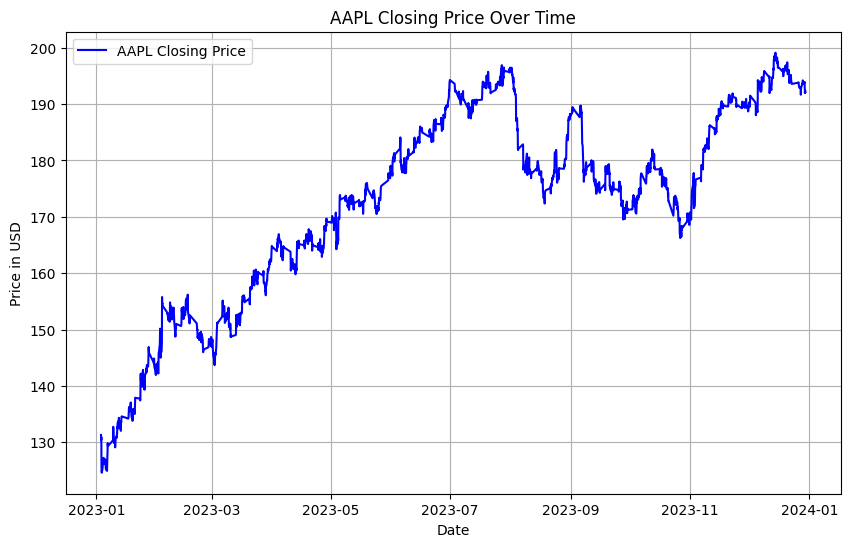

In [12]:
# Step 3: Visualize the Data
if df is not None:
    # Convert time column to a more usable format
    df['time'] = pd.to_datetime(df['time'])
    
    # Plot the Close Price over Time
    plt.figure(figsize=(10, 6))
    plt.plot(df['time'], df['close'], label=f'{symbol} Closing Price', color='b')
    plt.xlabel('Date')
    plt.ylabel('Price in USD')
    plt.title(f'{symbol} Closing Price Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data to visualize")

/Users/eliottvalette/Library/Mobile Documents/com~apple~CloudDocs/Documents/Codage /Trading LSTM/.venv/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


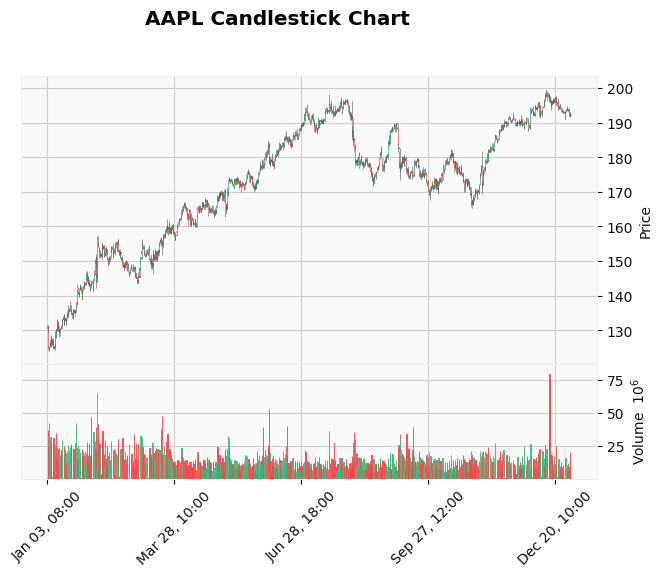

In [13]:
# Step 3: Visualize the Data with Candlestick Chart
df_for_candles = df.copy()
if df_for_candles is not None and len(df) > 1:
    # Set time as index for mplfinance
    df_for_candles.set_index('time', inplace=True)

    # Plot the data using mplfinance as candlestick chart
    mpf.plot(df_for_candles, type='candle', volume=True, title=f'{symbol} Candlestick Chart', style='yahoo')
else:
    print("No sufficient data to visualize")

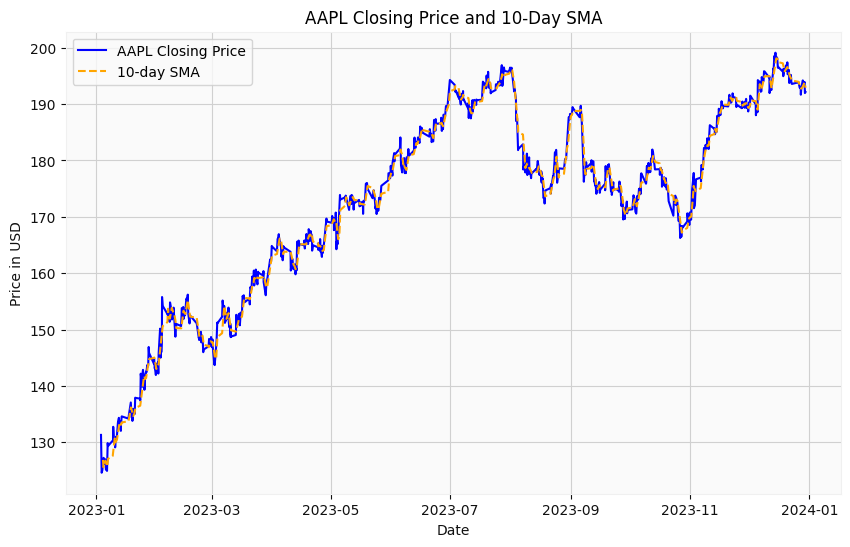

In [14]:
# Step 4: Optional - Add a Moving Average
if df is not None:
    # Calculate a simple moving average (SMA) with a 10-day window
    df['SMA_10'] = df['close'].rolling(window=10).mean()
    
    # Plot Close Price and the 10-day SMA
    plt.figure(figsize=(10, 6))
    plt.plot(df['time'], df['close'], label=f'{symbol} Closing Price', color='b')
    plt.plot(df['time'], df['SMA_10'], label='10-day SMA', color='orange', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price in USD')
    plt.title(f'{symbol} Closing Price and 10-Day SMA')
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
class LinearRegressor(nn.Module):
    def __init__(self):
        super(LinearRegressor, self).__init__()

        self.fc1 = nn.Linear(5, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x= self.relu(self.fc1(x))
        x = self.dropout(x)
        x= self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

    def forward(self, features):
        lstm_out, _ = self.lstm(features)
        tag_space = self.hidden2tag(self.dropout(self.batch_norm(lstm_out[:, -1, :])))
        return tag_space


In [17]:
def train_one_epoch(model, optimizer, criterion, dataloader, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (features, targets) in bar:

        batch_size = features.size(0)

        # Forward pass
        predicted_evolution = model(features)       

        # Compute the loss
        loss = criterion(predicted_evolution, targets)

        # Zero the parameter gradients
        optimizer.zero_grad()
    
        # Backward pass
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update the optimizer
        optimizer.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size            
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss)

    return epoch_loss


In [18]:
# Disabling gradient computation and saving memory
@torch.inference_mode()
def valid_one_epoch(model, criterion, dataloader, epoch):    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (features, targets) in bar:

        batch_size = features.size(0)

        predicted_evolution = model(features)       

        # Compute the loss
        loss = criterion(predicted_evolution, targets)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss)        
    return epoch_loss


In [19]:
def run_training(model, train_loader, valid_loader, optimizer, scheduler, criterion, num_epochs):
    
    start = time.time()
    
    # Deep copies the initial model weights to save the best model later
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Initializes the best ACC to 0.
    best_epoch_loss = 300
    
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        
        print(f"EPOCH [{epoch}/{num_epochs}]")
        
        # Train for one epoch
        train_epoch_loss = train_one_epoch(model = model, 
                                           optimizer = optimizer, 
                                           criterion = criterion, 
                                           dataloader = train_loader,
                                           epoch = epoch)
        # Valid for one epoch
        val_epoch_loss = valid_one_epoch(model = model, 
                                         criterion = criterion, 
                                         dataloader = valid_loader,
                                         epoch = epoch)
        
        # Save the loss and score in the history dict
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Save the model if it's getting better results
        if best_epoch_loss >= val_epoch_loss:
            print(f"{best_epoch_loss} Validation AUROC Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            
            best_epoch_loss = val_epoch_loss
            
            # Deepcopy the weights
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # Saves the weights in the working directory
            PATH = f"saved_weights/LSTM_Loss_{val_epoch_loss:.4f}_epoch{epoch}.bin".format(val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            
            print(f"Model Saved")
            
        print()

        scheduler.step()
    
    end = time.time()
    
    # Display the training time
    time_elapsed = end - start # in seconds
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600 , (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best LOSS: {:.6f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [20]:
# regressorModel = LinearRegressor()
lstmModel = LSTMModel(embedding_dim = 5, hidden_dim = 64)

In [21]:
optimizer = Adam(lstmModel.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
def criterion(outputs, targets):
    loss = nn.MSELoss()(outputs, targets)
    return loss
        

In [23]:
regressorModel, history = run_training(
    model = lstmModel,
    train_loader = train_loader,
    valid_loader = valid_loader,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion= criterion,
    num_epochs=20,   
)

EPOCH [1/20]


100%|██████████| 7/7 [00:00<00:00, 178.61it/s, Epoch=1, Train_Loss=0.121]


300 Validation AUROC Improved (300 ---> 0.12080459848529383)
Model Saved

EPOCH [2/20]


100%|██████████| 7/7 [00:00<00:00, 174.81it/s, Epoch=2, Train_Loss=0.063]


0.12080459848529383 Validation AUROC Improved (0.12080459848529383 ---> 0.06302140762755401)
Model Saved

EPOCH [3/20]


100%|██████████| 7/7 [00:00<00:00, 235.42it/s, Epoch=3, Train_Loss=0.0336]


0.06302140762755401 Validation AUROC Improved (0.06302140762755401 ---> 0.03364021715677885)
Model Saved

EPOCH [4/20]


100%|██████████| 7/7 [00:00<00:00, 228.44it/s, Epoch=4, Train_Loss=0.0227]


0.03364021715677885 Validation AUROC Improved (0.03364021715677885 ---> 0.02267165133901442)
Model Saved

EPOCH [5/20]


100%|██████████| 7/7 [00:00<00:00, 245.49it/s, Epoch=5, Train_Loss=0.0206]


0.02267165133901442 Validation AUROC Improved (0.02267165133901442 ---> 0.020590589751031927)
Model Saved

EPOCH [6/20]


100%|██████████| 7/7 [00:00<00:00, 185.54it/s, Epoch=6, Train_Loss=0.0154]


0.020590589751031927 Validation AUROC Improved (0.020590589751031927 ---> 0.015403162588149383)
Model Saved

EPOCH [7/20]


100%|██████████| 7/7 [00:00<00:00, 173.19it/s, Epoch=7, Train_Loss=0.0167]



EPOCH [8/20]


100%|██████████| 7/7 [00:00<00:00, 216.46it/s, Epoch=8, Train_Loss=0.017]



EPOCH [9/20]


100%|██████████| 7/7 [00:00<00:00, 217.50it/s, Epoch=9, Train_Loss=0.0122]


0.015403162588149383 Validation AUROC Improved (0.015403162588149383 ---> 0.012228950683928637)
Model Saved

EPOCH [10/20]


100%|██████████| 7/7 [00:00<00:00, 231.35it/s, Epoch=10, Train_Loss=0.013]



EPOCH [11/20]


100%|██████████| 7/7 [00:00<00:00, 112.03it/s, Epoch=11, Train_Loss=0.0123]



EPOCH [12/20]


100%|██████████| 7/7 [00:00<00:00, 214.47it/s, Epoch=12, Train_Loss=0.0161]



EPOCH [13/20]


100%|██████████| 7/7 [00:00<00:00, 245.61it/s, Epoch=13, Train_Loss=0.0135]



EPOCH [14/20]


100%|██████████| 7/7 [00:00<00:00, 204.87it/s, Epoch=14, Train_Loss=0.0149]



EPOCH [15/20]


100%|██████████| 7/7 [00:00<00:00, 224.33it/s, Epoch=15, Train_Loss=0.0125]



EPOCH [16/20]


100%|██████████| 7/7 [00:00<00:00, 219.48it/s, Epoch=16, Train_Loss=0.0126]



EPOCH [17/20]


100%|██████████| 7/7 [00:00<00:00, 243.89it/s, Epoch=17, Train_Loss=0.0117]


0.012228950683928637 Validation AUROC Improved (0.012228950683928637 ---> 0.011719916125020928)
Model Saved

EPOCH [18/20]


100%|██████████| 7/7 [00:00<00:00, 166.16it/s, Epoch=18, Train_Loss=0.0113]


0.011719916125020928 Validation AUROC Improved (0.011719916125020928 ---> 0.011295859975986498)
Model Saved

EPOCH [19/20]


100%|██████████| 7/7 [00:00<00:00, 150.47it/s, Epoch=19, Train_Loss=0.0111]


0.011295859975986498 Validation AUROC Improved (0.011295859975986498 ---> 0.011098000117022534)
Model Saved

EPOCH [20/20]


100%|██████████| 7/7 [00:00<00:00, 97.75it/s, Epoch=20, Train_Loss=0.0135]


Training complete in 0h 0m 7s
Best LOSS: 0.011098


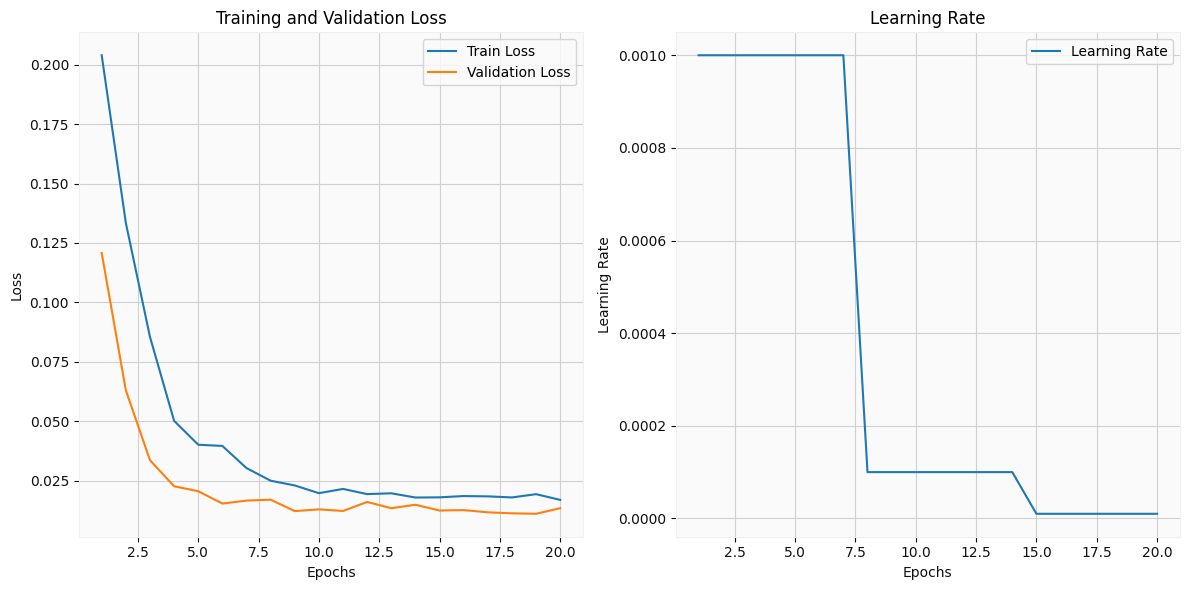

In [24]:
def plot_training_metrics(history):
    epochs = range(1, len(history['Train Loss']) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['Train Loss'], label='Train Loss')
    plt.plot(epochs, history['Valid Loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['lr'], label='Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call this function to plot training metrics
plot_training_metrics(history)

In [27]:
def create_test_loader(symbol, start_date, end_date, timeframe, backcandles, sc, is_filter, limit=1000):
    df , dataset_scaled, _  = prepare_data(symbol, start_date, end_date, timeframe, is_filter, limit, is_training = False, sc = sc)
    
    # Create the sliding window feature set
    X_dataset = dataset_scaled[['open', 'high', 'low', 'close', 'volume']]
    y_dataset = dataset_scaled[['interval_evolution']].values

    X = []
    for i in range(backcandles, len(X_dataset) - 1):
        window = []
        for j in range(X_dataset.shape[1]):
            window.append(X_dataset.iloc[i-backcandles:i, j].values) 
        X.append(np.array(window))
    X = np.array(X) 
    X = X.transpose(0, 2, 1)

    y = np.array(y_dataset[1 + backcandles:,-1])
    y = np.reshape(y, (len(y), 1))
    
    test_dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    return test_loader, df, dataset_scaled

symbol = 'AAPL'
start_date = '2024-01-01'
end_date = '2024-10-01'

# Create test loader
test_loader, df_test, dataset_scaled_test = create_test_loader(symbol, start_date, end_date, timeframe, backcandles, sc, is_filter = False, limit = 1000)

100%|██████████| 939/939 [00:01<00:00, 894.40it/s]

Final Portfolio Value: 1024.71
Augmentation of the portfolio: 2.47%


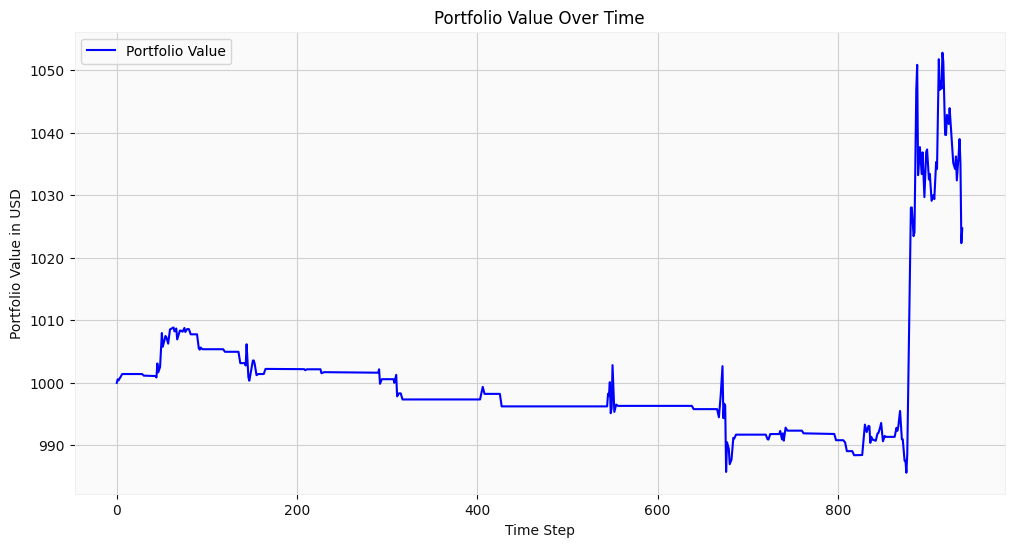

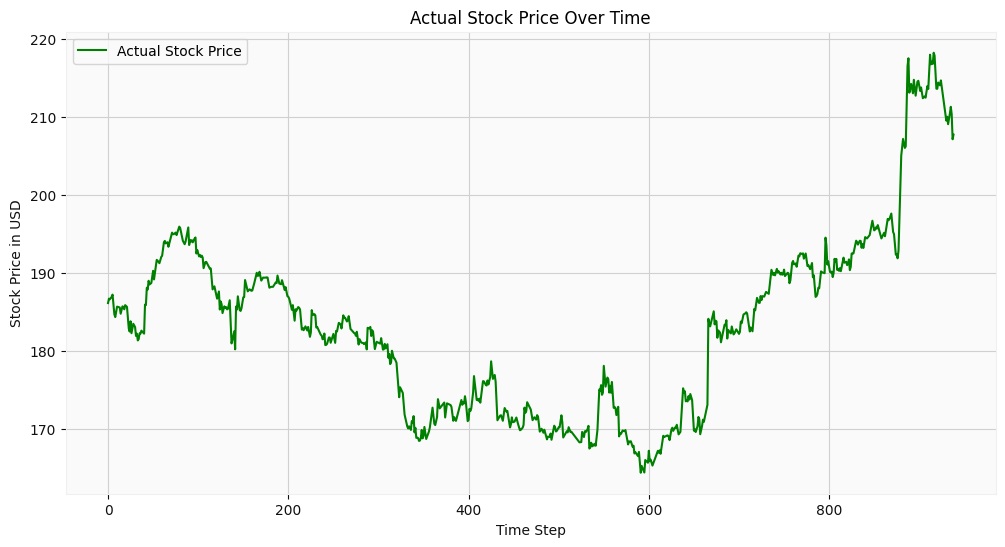

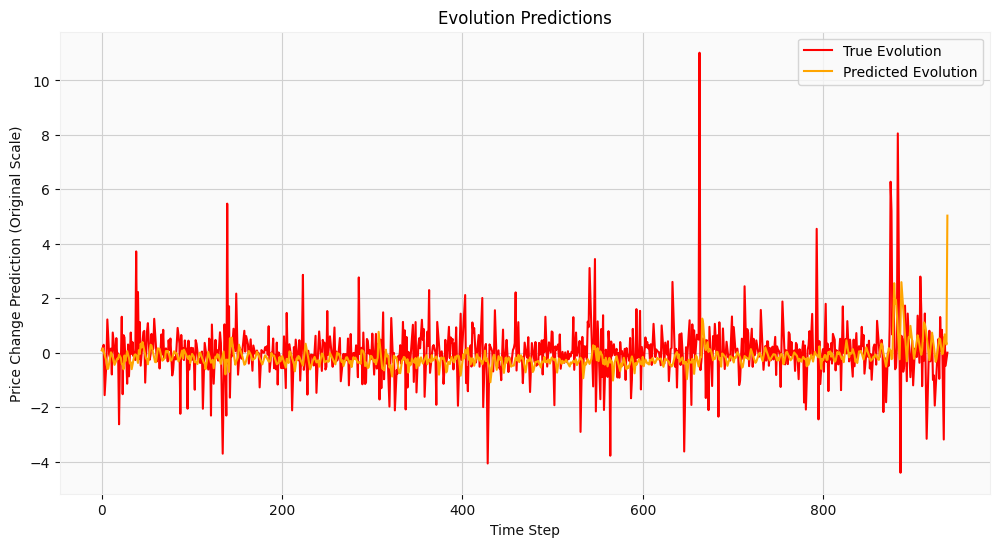

       Predicted Evolution
count           939.000000
mean             -0.167946
std               0.376901
min              -1.086259
25%              -0.338253
50%              -0.224725
75%              -0.069323
max               5.034679


In [46]:
# Define initial parameters for the simulation
initial_capital = 1000  # Starting capital in dollars
capital = initial_capital
shares_owned = 0
buy_threshold = 0.02  # If the model predicts an increase of 2% or more, buy
sell_threshold = -0.02  # If the model predicts a decrease of 2% or more, sell

# To store portfolio values and returns
portfolio_values = []

def simulate_investment(model, dataloader, capital, shares_owned, scaler):
    model.eval()
    true_evolutions = []
    predicted_evolutions = []
    current_prices = []

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (features, targets) in bar:
        # Predicted change in normalized price
        predicted_evolution = model(features).detach().numpy().flatten()
        true_evolution = targets.numpy().flatten()

        # Dummy arrays for inverse transform
        dummy_array_pred = np.zeros((1, 6))  # Create a dummy array with the same number of features used during training
        dummy_array_pred[:, -1] = predicted_evolution  # Assign the predicted evolution to the corresponding position
        
        dummy_array_target = np.zeros((1, 6))
        dummy_array_target[:, -1] = true_evolution

        # Inverse transform to get original scale
        predicted_original = scaler.inverse_transform(dummy_array_pred)[:, -1]  # Use only the interval_evolution column
        true_original = scaler.inverse_transform(dummy_array_target)[:, -1]

        # Get current 'close' price in normalized form
        current_price_norm = features[:, -1, 3].numpy()  # Get current 'close' price (normalized)
        current_price_norm = current_price_norm[0]  # Extract the scalar value from the array

        # Create a dummy array for inverse transform of current price
        dummy_array_price = np.zeros((1, 6))  # Create a dummy array to inverse transform the current price
        dummy_array_price[:, 3] = current_price_norm  # Assign the current 'close' price to the corresponding position

        # Inverse transform to get current price in original scale
        current_price = scaler.inverse_transform(dummy_array_price)[:, 3]

        # Extract the scalar value from the transformed array
        current_price = current_price[0]

        # Simulate investment based on model prediction
        if predicted_original >= buy_threshold and capital >= current_price:
            # Buy one share if the predicted change is positive and capital allows
            shares_owned += 1
            capital -= current_price
            # print(f"Bought 1 share at {current_price:.2f}, Capital: {capital:.2f}, Shares Owned: {shares_owned}, On step : {step}")

        elif predicted_original <= sell_threshold and shares_owned > 0:
            # Sell one share if the predicted change is negative and shares are available
            shares_owned -= 1
            capital += current_price
            # print(f"Sold 1 share at {current_price:.2f}, Capital: {capital:.2f}, Shares Owned: {shares_owned}, On step : {step}")

        # Calculate portfolio value after each decision
        portfolio_value = capital + shares_owned * current_price
        portfolio_values.append(portfolio_value)

        true_evolutions.append(true_original)
        predicted_evolutions.append(predicted_original)
        current_prices.append(current_price)

    print("Final Portfolio Value: {:.2f}".format(portfolio_values[-1]))
    print("Augmentation of the portfolio: {:.2%}".format((portfolio_values[-1] - initial_capital) / initial_capital))

    # Plot final results
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='Portfolio Value', color='blue')
    plt.xlabel('Time Step')
    plt.ylabel('Portfolio Value in USD')
    plt.title('Portfolio Value Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Actual Stock
    plt.figure(figsize=(12, 6))
    plt.plot(current_prices, label='Actual Stock Price', color='green')
    plt.xlabel('Time Step')
    plt.ylabel('Stock Price in USD')
    plt.title('Actual Stock Price Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(true_evolutions, label='True Evolution', color='red')
    plt.plot(predicted_evolutions, label='Predicted Evolution', color='orange')
    plt.xlabel('Time Step')
    plt.ylabel('Price Change Prediction (Original Scale)')
    plt.title('Evolution Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()

    predicted_evolutions_df = pd.DataFrame(predicted_evolutions, columns=['Predicted Evolution'])
    print(predicted_evolutions_df.describe())

# Call the function to simulate investment
simulate_investment(lstmModel, test_loader, capital, shares_owned, sc)
